<a href="https://colab.research.google.com/github/AllisonOge/predictive_modeling/blob/main/baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import warnings

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
# increase the figure size
sns.set(rc={'figure.figsize': (15, 5)})
sns.set_style("whitegrid")

In [3]:
sensor_df = pd.read_csv("https://raw.githubusercontent.com/AllisonOge/predictive_modeling/main/data/sensor_ml.csv", index_col="id")
# sensor_df = pd.read_csv("sensor_ml.csv", index_col="id")

In [4]:
sensor_copy_df = sensor_df
sensor_copy_df = sensor_copy_df.drop_duplicates(subset="created_at")
sensor_copy_df = sensor_copy_df.set_index("created_at")

In [5]:
sensor_copy_df

,chan_1,chan_2,chan_3,chan_4
created_at,,,,
2022-11-15 16:14:18.829480,1,0,0,0
2022-11-15 16:14:18.914676,1,0,0,0
2022-11-15 16:14:18.983745,1,0,0,0
2022-11-15 16:14:19.059611,1,0,0,0
2022-11-15 16:14:19.134008,1,0,0,0
...,...,...,...,...
2022-11-15 16:44:18.563776,1,1,1,1
2022-11-15 16:44:18.693114,1,1,1,1
2022-11-15 16:44:18.755782,1,1,1,1


In [6]:
idle_times_df = pd.read_csv("https://raw.githubusercontent.com/AllisonOge/predictive_modeling/main/data/idletimes.csv", index_col="created_at")
idle_times_df

,chan_1,chan_2,chan_3,chan_4
created_at,,,,
2022-11-15 16:14:18.829480,0,16,16,16
2022-11-15 16:14:18.914676,0,15,15,15
2022-11-15 16:14:18.983745,0,14,14,14
2022-11-15 16:14:19.059611,0,13,13,13
2022-11-15 16:14:19.134008,0,12,12,12
...,...,...,...,...
2022-11-15 16:44:18.563776,0,0,0,0
2022-11-15 16:44:18.693114,0,0,0,0
2022-11-15 16:44:18.755782,0,0,0,0


In [7]:
def df_to_X_y(df1, df2, window_size=10):
  X = []
  y = []
  for i in range(df1.shape[0]-window_size):
    X.append([r for r in df1.to_numpy()[i:i+window_size]])
    y.append(df2.to_numpy()[i+window_size])
  return np.array(X), np.array(y)

In [8]:
scaler = MinMaxScaler()
idle_times_transformed_df = pd.DataFrame(scaler.fit_transform((idle_times_df)), index=idle_times_df.index, columns=idle_times_df.columns)

In [10]:
X, y = df_to_X_y(sensor_copy_df, idle_times_transformed_df, window_size=25)
X.shape, y.shape

((23545, 25, 4), (23545, 4))

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)
X_train.shape, X_test.shape, X_val.shape

((18836, 25, 4), (2354, 25, 4), (2355, 25, 4))

## Build the model 🧠

In [12]:
def build_model(input_shape):
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(input_shape),
      tf.keras.layers.LSTM(45, return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.LSTM(45, return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.LSTM(45),
      tf.keras.layers.Dense(45, activation="relu"),
      tf.keras.layers.Dense(4, activation="relu")
  ])

In [13]:
model = build_model((X.shape[1], X.shape[2]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 45)            9000      
                                                                 
 dropout (Dropout)           (None, 25, 45)            0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 45)            16380     
                                                                 
 dropout_1 (Dropout)         (None, 25, 45)            0         
                                                                 
 lstm_2 (LSTM)               (None, 45)                16380     
                                                                 
 dense (Dense)               (None, 45)                2070      
                                                                 
 dense_1 (Dense)             (None, 4)                 1

In [14]:
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

In [15]:
callback = tf.keras.callbacks.ModelCheckpoint("ckpt", verbose=1, save_best_only=True, monitor="val_loss", mode="min")

In [16]:
history = model.fit(X_train, y_train, batch_size=16, epochs=40, callbacks=[callback], validation_data=(X_val, y_val))

Epoch 1/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.6364
Epoch 1: val_loss improved from inf to 0.01211, saving model to ckpt


1178/1178 [==============================] - 34s 21ms/step - loss: 0.0128 - accuracy: 0.6364 - val_loss: 0.0121 - val_accuracy: 0.6408
Epoch 2/40
1175/1178 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.6799
Epoch 2: val_loss improved from 0.01211 to 0.01118, saving model to ckpt


1178/1178 [==============================] - 22s 19ms/step - loss: 0.0118 - accuracy: 0.6798 - val_loss: 0.0112 - val_accuracy: 0.6900
Epoch 3/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.7097
Epoch 3: val_loss improved from 0.01118 to 0.01092, saving model to ckpt


1178/1178 [==============================] - 22s 19ms/step - loss: 0.0112 - accuracy: 0.7098 - val_loss: 0.0109 - val_accuracy: 0.7316
Epoch 4/40
1174/1178 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.7243
Epoch 4: val_loss improved from 0.01092 to 0.01067, saving model to ckpt


1178/1178 [==============================] - 23s 20ms/step - loss: 0.0110 - accuracy: 0.7248 - val_loss: 0.0107 - val_accuracy: 0.7571
Epoch 5/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.7412
Epoch 5: val_loss did not improve from 0.01067
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0108 - accuracy: 0.7412 - val_loss: 0.0107 - val_accuracy: 0.7813
Epoch 6/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.7524
Epoch 6: val_loss improved from 0.01067 to 0.01036, saving model to ckpt


1178/1178 [==============================] - 21s 18ms/step - loss: 0.0106 - accuracy: 0.7524 - val_loss: 0.0104 - val_accuracy: 0.7817
Epoch 7/40
1175/1178 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.7637
Epoch 7: val_loss improved from 0.01036 to 0.01029, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0104 - accuracy: 0.7639 - val_loss: 0.0103 - val_accuracy: 0.7860
Epoch 8/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.7676
Epoch 8: val_loss improved from 0.01029 to 0.01025, saving model to ckpt


1178/1178 [==============================] - 21s 18ms/step - loss: 0.0103 - accuracy: 0.7676 - val_loss: 0.0103 - val_accuracy: 0.7656
Epoch 9/40
1173/1178 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.7738
Epoch 9: val_loss did not improve from 0.01025
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0101 - accuracy: 0.7740 - val_loss: 0.0104 - val_accuracy: 0.7979
Epoch 10/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.7796
Epoch 10: val_loss improved from 0.01025 to 0.01015, saving model to ckpt


1178/1178 [==============================] - 21s 18ms/step - loss: 0.0100 - accuracy: 0.7797 - val_loss: 0.0101 - val_accuracy: 0.7877
Epoch 11/40
1172/1178 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.7832
Epoch 11: val_loss improved from 0.01015 to 0.00995, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0098 - accuracy: 0.7833 - val_loss: 0.0100 - val_accuracy: 0.7741
Epoch 12/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.7802
Epoch 12: val_loss improved from 0.00995 to 0.00987, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0097 - accuracy: 0.7802 - val_loss: 0.0099 - val_accuracy: 0.7932
Epoch 13/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.7824
Epoch 13: val_loss improved from 0.00987 to 0.00942, saving model to ckpt


1178/1178 [==============================] - 22s 19ms/step - loss: 0.0095 - accuracy: 0.7824 - val_loss: 0.0094 - val_accuracy: 0.7890
Epoch 14/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.7852
Epoch 14: val_loss did not improve from 0.00942
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0094 - accuracy: 0.7854 - val_loss: 0.0095 - val_accuracy: 0.7970
Epoch 15/40
1174/1178 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.7895
Epoch 15: val_loss improved from 0.00942 to 0.00917, saving model to ckpt


1178/1178 [==============================] - 21s 18ms/step - loss: 0.0092 - accuracy: 0.7898 - val_loss: 0.0092 - val_accuracy: 0.8013
Epoch 16/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.7930
Epoch 16: val_loss did not improve from 0.00917
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0090 - accuracy: 0.7930 - val_loss: 0.0094 - val_accuracy: 0.8030
Epoch 17/40
1173/1178 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.7933
Epoch 17: val_loss improved from 0.00917 to 0.00912, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0090 - accuracy: 0.7931 - val_loss: 0.0091 - val_accuracy: 0.8021
Epoch 18/40
1174/1178 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.7979
Epoch 18: val_loss improved from 0.00912 to 0.00897, saving model to ckpt


1178/1178 [==============================] - 21s 18ms/step - loss: 0.0088 - accuracy: 0.7978 - val_loss: 0.0090 - val_accuracy: 0.8106
Epoch 19/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.7909
Epoch 19: val_loss improved from 0.00897 to 0.00892, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0087 - accuracy: 0.7909 - val_loss: 0.0089 - val_accuracy: 0.8115
Epoch 20/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.7983
Epoch 20: val_loss did not improve from 0.00892
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0085 - accuracy: 0.7983 - val_loss: 0.0092 - val_accuracy: 0.8047
Epoch 21/40
1175/1178 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.7982
Epoch 21: val_loss improved from 0.00892 to 0.00865, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0086 - accuracy: 0.7983 - val_loss: 0.0086 - val_accuracy: 0.8123
Epoch 22/40
1174/1178 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.7998
Epoch 22: val_loss improved from 0.00865 to 0.00856, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0084 - accuracy: 0.7997 - val_loss: 0.0086 - val_accuracy: 0.8161
Epoch 23/40
1173/1178 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.7974
Epoch 23: val_loss improved from 0.00856 to 0.00849, saving model to ckpt


1178/1178 [==============================] - 22s 19ms/step - loss: 0.0084 - accuracy: 0.7975 - val_loss: 0.0085 - val_accuracy: 0.8200
Epoch 24/40
1173/1178 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.8004
Epoch 24: val_loss improved from 0.00849 to 0.00840, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0082 - accuracy: 0.8005 - val_loss: 0.0084 - val_accuracy: 0.8102
Epoch 25/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.8009
Epoch 25: val_loss improved from 0.00840 to 0.00827, saving model to ckpt


1178/1178 [==============================] - 21s 18ms/step - loss: 0.0081 - accuracy: 0.8009 - val_loss: 0.0083 - val_accuracy: 0.8051
Epoch 26/40
1174/1178 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.8027
Epoch 26: val_loss did not improve from 0.00827
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0081 - accuracy: 0.8027 - val_loss: 0.0085 - val_accuracy: 0.8123
Epoch 27/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.8043
Epoch 27: val_loss did not improve from 0.00827
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0079 - accuracy: 0.8044 - val_loss: 0.0083 - val_accuracy: 0.8166
Epoch 28/40
1173/1178 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.8055
Epoch 28: val_loss improved from 0.00827 to 0.00820, saving model to ckpt


1178/1178 [==============================] - 21s 18ms/step - loss: 0.0079 - accuracy: 0.8056 - val_loss: 0.0082 - val_accuracy: 0.8098
Epoch 29/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.8081
Epoch 29: val_loss did not improve from 0.00820
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0078 - accuracy: 0.8081 - val_loss: 0.0086 - val_accuracy: 0.8102
Epoch 30/40
1174/1178 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.8090
Epoch 30: val_loss did not improve from 0.00820
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0078 - accuracy: 0.8090 - val_loss: 0.0083 - val_accuracy: 0.8229
Epoch 31/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.8114
Epoch 31: val_loss improved from 0.00820 to 0.00800, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0077 - accuracy: 0.8115 - val_loss: 0.0080 - val_accuracy: 0.8161
Epoch 32/40
1173/1178 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.8061
Epoch 32: val_loss improved from 0.00800 to 0.00773, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0076 - accuracy: 0.8057 - val_loss: 0.0077 - val_accuracy: 0.8238
Epoch 33/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.8066
Epoch 33: val_loss did not improve from 0.00773
1178/1178 [==============================] - 12s 10ms/step - loss: 0.0075 - accuracy: 0.8065 - val_loss: 0.0078 - val_accuracy: 0.8280
Epoch 34/40
1175/1178 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.8093
Epoch 34: val_loss did not improve from 0.00773
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0074 - accuracy: 0.8095 - val_loss: 0.0078 - val_accuracy: 0.8144
Epoch 35/40
1175/1178 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.8093
Epoch 35: val_loss did not improve from 0.00773
1178/1178 [==============================] - 11s 9ms/step - loss: 0.0073 - accuracy: 0.8094 - val_loss: 0.0080 - val_accuracy: 0.8217
Epoch 36/40
1175/1178

1178/1178 [==============================] - 21s 18ms/step - loss: 0.0072 - accuracy: 0.8115 - val_loss: 0.0077 - val_accuracy: 0.8149
Epoch 38/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.8126
Epoch 38: val_loss improved from 0.00770 to 0.00756, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0071 - accuracy: 0.8126 - val_loss: 0.0076 - val_accuracy: 0.8276
Epoch 39/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.8120
Epoch 39: val_loss improved from 0.00756 to 0.00755, saving model to ckpt


1178/1178 [==============================] - 21s 18ms/step - loss: 0.0072 - accuracy: 0.8120 - val_loss: 0.0075 - val_accuracy: 0.8123
Epoch 40/40
1174/1178 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.8087
Epoch 40: val_loss improved from 0.00755 to 0.00755, saving model to ckpt


1178/1178 [==============================] - 22s 18ms/step - loss: 0.0071 - accuracy: 0.8085 - val_loss: 0.0075 - val_accuracy: 0.8268


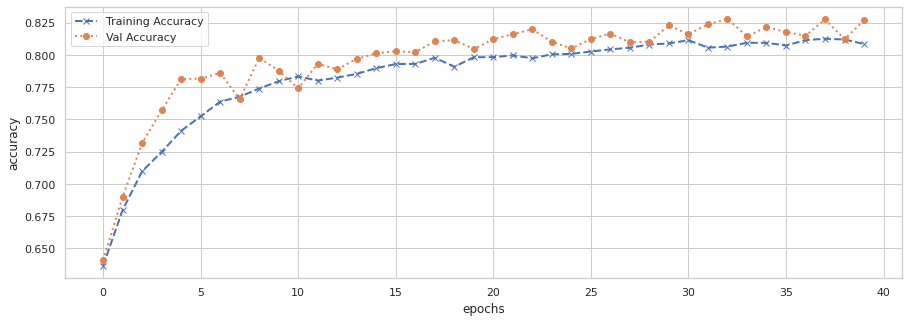

In [17]:
plt.plot(history.history["accuracy"], label="Training Accuracy", marker="x", ls="--", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Val Accuracy", marker="o", ls=":", linewidth=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.savefig("./images/training.png")

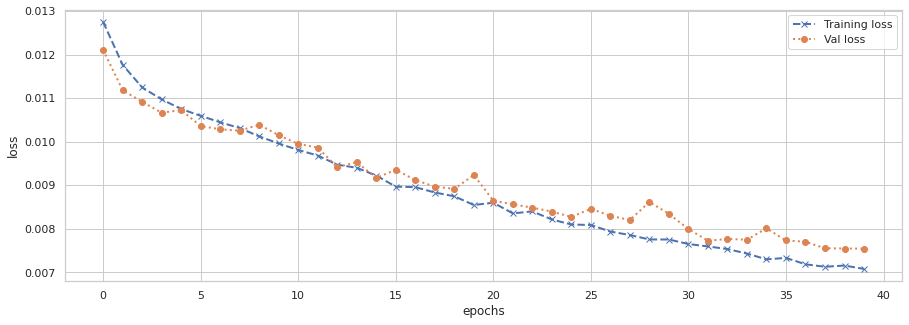

In [18]:
plt.plot(history.history["loss"], label="Training loss", marker="x", ls="--", linewidth=2)
plt.plot(history.history["val_loss"], label="Val loss", marker="o", ls=":", linewidth=2)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("./images/loss.png")

In [19]:
model.load_weights("./models/ckpt")
test_preds = model.predict(X_test)
test_preds

74/74 [==============================] - 1s 4ms/step


array([[0.01174822, 0.        , 0.        , 0.11064084],
       [0.        , 0.11059697, 0.        , 0.        ],
       [0.0160726 , 0.08786056, 0.        , 0.        ],
       ...,
       [0.        , 0.13628817, 0.        , 0.        ],
       [0.        , 0.        , 0.23898104, 0.08177391],
       [0.        , 0.10330996, 0.06313723, 0.        ]], dtype=float32)

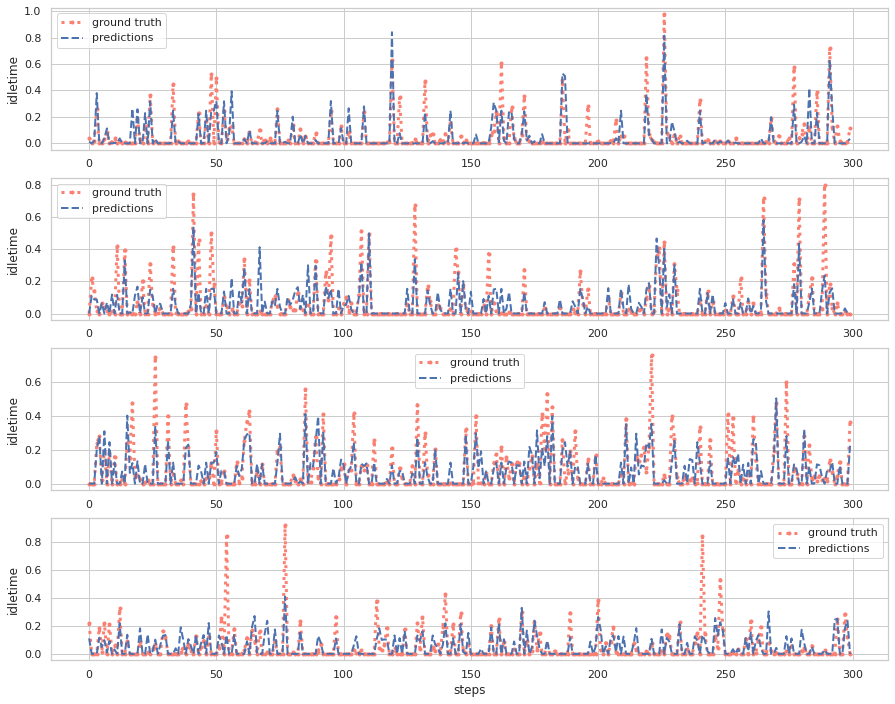

In [20]:
nchannels = y.shape[1]
fig, ax = plt.subplots(nrows=nchannels, ncols=1, figsize=(15, 12))
for i in range(nchannels):
  ax[i].plot(y_test[:300, i], label="ground truth", marker=".", ls=":", linewidth=3, color="salmon")
  ax[i].plot(test_preds[:300, i], label="predictions", ls="--", linewidth=2)
  ax[i].legend()
  ax[i].set_ylabel("idletime")
  if i == nchannels-1:
    ax[i].set_xlabel("steps")
plt.savefig("./images/predictions.png")

### Save the model 💾

In [21]:
def save_model(model, filename="model.tflite"):
  # convert the keras model to tflite
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
  ]

  tflite_model = converter.convert()

  # save the tflite model
  with open(filename, "wb") as f:
    f.write(tflite_model)

In [23]:
save_model(model, "./models/model.tflite")